In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

In [58]:
df = pd.read_csv("data/esg_return_vol_clean_data.csv")
df.head()

,risk_rating_score,risk_rating_assessment,industry_group,identifier,country,company_name,ticker,return,volatility
0,28.9,Medium Risk,Retailing,NAS:FLWS,United States of America,1-800-flowers-com-inc,FLWS,-0.2236,0.4191
1,27.7,Medium Risk,Telecommunication Services,ETR:1U1,Germany,1-1-ag,1U1.DE,-0.3420,0.2791
2,22.5,Medium Risk,Pharmaceuticals,NAS:TXG,United States of America,10x-genomics-inc,TXG,-0.7357,0.6540
3,16.3,Low Risk,Software & Services,WAR:11B,Poland,11-bit-studios-sa,11B.WA,-0.6866,0.6431
4,35.0,High Risk,Banks,NAS:SRCE,United States of America,1st-source-corp,SRCE,0.1023,0.3087


In [56]:
def prepare_categorical_data(df):
    risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    # Convert to categorical with specified order
    df['risk_rating_assessment'] = pd.Categorical(
        df['risk_rating_assessment'],
        categories=risk_order,
        ordered=True
    )
    # Sort by risk rating
    df = df.sort_values('risk_rating_assessment')
    return df


In [20]:
def basic_analysis(df):
    """Perform initial statistical analysis"""
    # Summary statistics by ESG group
    summary = df.groupby('risk_rating_assessment').agg({
        'return': ['mean', 'median', 'std', 'count'],
        'volatility': ['mean', 'median'],
        'risk_rating_score': ['mean', 'median']  # Show ESG score relationship
    }).round(4)
    
    print("Performance by ESG Group:")
    print(summary)
    
    # Correlation analysis
    corr_matrix = df[['risk_rating_score', 'return', 'volatility']].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    return summary, corr_matrix
def create_visualizations(df):
    """Generate all visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Risk Rating Performance Analysis', fontsize=16)
    
    # Boxplot of returns by risk rating
    sns.boxplot(x='risk_rating_assessment', y='return', data=df, ax=axes[0, 0],
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[0, 0].set_title('Distribution of Returns by Risk Rating')
    axes[0, 0].set_ylabel('Return')
    axes[0, 0].set_xlabel('Risk Rating')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Scatter plot of ESG score vs returns
    sns.regplot(x='risk_rating_score', y='return', data=df, ax=axes[0, 1], 
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    axes[0, 1].set_title('ESG Score vs. Returns')
    axes[0, 1].set_ylabel('Return')
    axes[0, 1].set_xlabel('ESG Score (Risk Rating)')

    
    # Violin plot of volatility by ESG group
    # sns.violinplot(x='risk_rating_score', y='volatility', data=df, ax=axes[1, 0])
    # axes[1, 0].set_title('Volatility by ESG Group')
    # axes[1, 0].set_ylabel('Volatility')
    # axes[1, 0].set_xlabel('ESG Rating Group')
    sns.boxplot(x='risk_rating_assessment', y='volatility', data=df, ax=axes[1, 0],
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[1, 0].set_title('Distribution of Volatility by Risk Rating')
    axes[1, 0].set_ylabel('Volatility')
    axes[1, 0].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Bar plot of average returns
    (df.groupby('risk_rating_assessment')['return']
       .mean()
       .loc[['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']]
       .plot(kind='bar', ax=axes[1, 1]))
    axes[1, 1].set_title('Average Returns by Risk Rating')
    axes[1, 1].set_ylabel('Average Return')
    axes[1, 1].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    # plt.savefig('risk_rating_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


def perform_statistical_tests(df):
    """Conduct hypothesis testing"""
    groups = {}
    risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    
    for risk_group in risk_order:
        groups[risk_group] = df[df['risk_rating_assessment'] == risk_group]['return']
    
    # ANOVA test for multiple group comparison
    f_val, p_val = stats.f_oneway(*[groups[g].dropna() for g in risk_order])
    print(f"\nANOVA Results: F-value={f_val:.4f}, p-value={p_val:.4f}")
    
    # Pairwise t-tests between groups
    from itertools import combinations
    print("\nPairwise t-tests (Bonferroni corrected):")
    for group1, group2 in combinations(risk_order, 2):
        # Drop NA values for t-test
        data1 = groups[group1].dropna()
        data2 = groups[group2].dropna()
        
        if len(data1) > 1 and len(data2) > 1:  # Need at least 2 observations
            t_val, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            # Bonferroni correction for multiple comparisons (10 possible pairs)
            corrected_p = p_val * 10
            sig = '*' if corrected_p < 0.05 else ''
            print(f"{group1} vs {group2}: t={t_val:.4f}, p={corrected_p:.4f}{sig}")
        else:
            print(f"{group1} vs {group2}: Insufficient data")


def industry_adjusted_analysis(df):
    """Control for industry effects"""
    # Calculate industry-adjusted returns
    df['industry_mean_return'] = df.groupby('industry_group')['return'].transform('mean')
    df['adjusted_return'] = df['return'] - df['industry_mean_return']
    
    # Plot adjusted returns
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk_rating_assessment', y='adjusted_return', data=df,
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    plt.title('Industry-Adjusted Returns by Risk Rating')
    plt.ylabel('Industry-Adjusted Return')
    plt.xlabel('Risk Rating')
    plt.xticks(rotation=45)
    # plt.savefig('industry_adjusted_returns.png', dpi=300, bbox_inches='tight')
    plt.show()



Performance by ESG Group:
                        return                       volatility          \
                          mean  median     std count       mean  median   
risk_rating_assessment                                                    
High Risk               0.1063  0.0412  0.4962  2742     0.4444  0.3890   
Low Risk                0.1140  0.0352  1.7872  2828     0.4263  0.3194   
Medium Risk             0.1189  0.0472  0.6820  4646     0.5592  0.3624   
Negligible Risk         0.0517  0.0173  0.3098   206     0.2879  0.2608   
Severe Risk             0.0906  0.0321  0.4608  1007     0.4604  0.3934   

                       risk_rating_score         
                                    mean median  
risk_rating_assessment                           
High Risk                        34.1376   33.8  
Low Risk                         16.1474   16.5  
Medium Risk                      24.9802   25.0  
Negligible Risk                   8.4199    8.6  
Severe Risk            

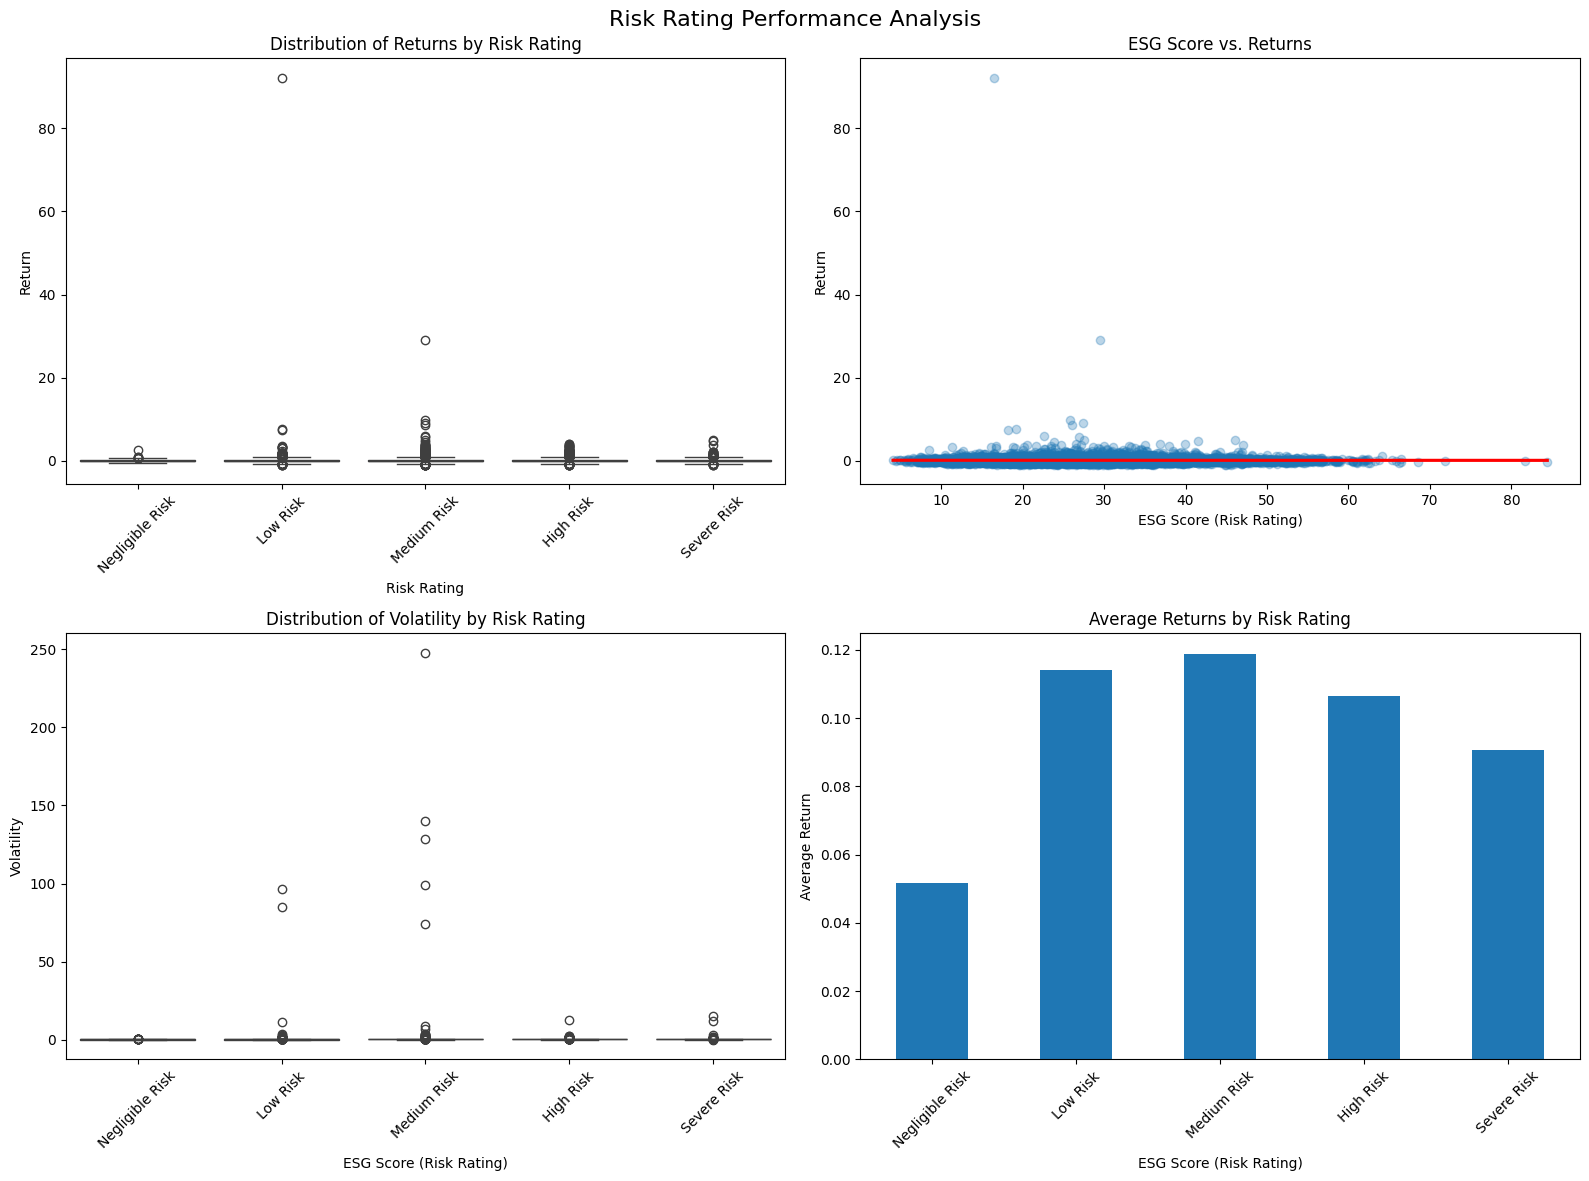

In [21]:
# Basic analysis
summary_stats, corr_matrix = basic_analysis(df)
# Visualization
create_visualizations(df)
# Statistical testing
# perform_statistical_tests(df)
# Industry-adjusted analysis if industry data available
# industry_adjusted_analysis(df)


In [22]:
def find_extreme_outliers(df, column_name):
    try:
        # Calculate quartiles
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for extreme outliers (3 times the IQR)
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Identify extreme outliers
        extreme_outliers = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
        return extreme_outliers

    except TypeError:
        print(f"Column '{column_name}' is not numeric and cannot be used to find outliers using the IQR method.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [60]:
df_outlier=df[find_extreme_outliers(df, 'return')]
df_outlier_gr=df_outlier.groupby('country')
print('Total data', len(df))
print('Total outlier data ', len(df_outlier))
df_outlier_gr.size()
df_use=df[~find_extreme_outliers(df, 'return')]
df_use = prepare_categorical_data(df_use)
print('Data is use ',len(df_use))

Total data 11429
Total outlier data  168
Data is use  11261


In [25]:
def basic_analysis_return(df):
    """Perform initial statistical analysis"""
    # Summary statistics by ESG group
    summary = df.groupby('risk_rating_assessment').agg({
        'return': ['mean', 'median', 'std', 'count'],
        'risk_rating_score': ['mean', 'median']  # Show ESG score relationship
    }).round(4)
    
    print("Performance by ESG Group:")
    print(summary)
    
    # Correlation analysis
    corr_matrix = df[['risk_rating_score', 'return']].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    return summary, corr_matrix
def create_visualizations_return(df):
    """Generate all visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ESG Performance Analysis', fontsize=16)
    
    # Boxplot of returns by ESG group
    sns.boxplot(x='risk_rating_assessment', y='return', data=df, ax=axes[0, 0], 
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[0, 0].set_title('Distribution of Returns by ESG Group')
    axes[0, 0].set_ylabel('Return')
    axes[0, 0].set_xlabel('ESG Rating Group')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Scatter plot of ESG score vs returns
    
    sns.scatterplot(x='risk_rating_score', y='return', hue='risk_rating_assessment',
                    data=df, ax=axes[0, 1], palette='crest',
                    hue_order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    # Calculate the regression line using np.polyfit
    m, b = np.polyfit(df['risk_rating_score'], df['return'], 1)  # 1 for a linear fit
    axes[0, 1].plot(df['risk_rating_score'], m * df['risk_rating_score'] + b, color='red', linestyle='--')
    
    axes[0, 1].set_title('ESG Score (Risk Rating) vs. Returns')
    axes[0, 1].set_ylabel('Return')
    axes[0, 1].set_xlabel('ESG Score (risk_rating_score)')
    axes[0, 1].legend(title='ESG Score (Risk Rating)')

    
    # Violin plot of volatility by risk rating
    sns.violinplot(x='risk_rating_assessment', y='return', data=df, ax=axes[1, 0],
                   order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[1, 0].set_title('Return by Risk Rating')
    axes[1, 0].set_ylabel('Return')
    axes[1, 0].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    
    # Bar plot of average returns
    (df.groupby('risk_rating_assessment')['return']
       .mean()
       .loc[['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']]
       .plot(kind='bar', ax=axes[1, 1]))
    axes[1, 1].set_title('Average Returns by ESG Score (Risk Rating)')
    axes[1, 1].set_ylabel('Average Return')
    axes[1, 1].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    
    plt.tight_layout()
    # plt.savefig('esg_performance_analysis.png', dpi=300)
    plt.show()

def perform_statistical_tests_return(df):
    """Conduct hypothesis testing"""
    groups = {}
    risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    
    for risk_group in risk_order:
        groups[risk_group] = df[df['risk_rating_assessment'] == risk_group]['return']
    
    # ANOVA test for multiple group comparison
    f_val, p_val = stats.f_oneway(*[groups[g].dropna() for g in risk_order])
    print(f"\nANOVA Results: F-value={f_val:.4f}, p-value={p_val:.4f}")
    
    # Pairwise t-tests between groups
    from itertools import combinations
    print("\nPairwise t-tests (Bonferroni corrected):")
    for group1, group2 in combinations(risk_order, 2):
        # Drop NA values for t-test
        data1 = groups[group1].dropna()
        data2 = groups[group2].dropna()
        
        if len(data1) > 1 and len(data2) > 1:  # Need at least 2 observations
            t_val, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            # Bonferroni correction for multiple comparisons (10 possible pairs)
            corrected_p = p_val * 10
            sig = '*' if corrected_p < 0.05 else ''
            print(f"{group1} vs {group2}: t={t_val:.4f}, p={corrected_p:.4f}{sig}")
        else:
            print(f"{group1} vs {group2}: Insufficient data")


def industry_adjusted_analysis_return(df):
    """Control for industry effects"""
    # Calculate industry-adjusted returns
    df['industry_mean_return'] = df.groupby('industry_group')['return'].transform('mean')
    df['adjusted_return'] = df['return'] - df['industry_mean_return']
    
    # Plot adjusted returns
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk_rating_assessment', y='adjusted_return', data=df,
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    plt.title('Industry-Adjusted Returns by ESG Score (Risk Rating)')
    plt.ylabel('Industry-Adjusted Return')
    plt.xlabel('ESG Score (Risk Rating)')
    plt.xticks(rotation=45)
    # plt.savefig('industry_adjusted_returns.png', dpi=300, bbox_inches='tight')
    plt.show()


Performance by ESG Group:
                        return                       risk_rating_score       
                          mean  median     std count              mean median
risk_rating_assessment                                                       
High Risk               0.0650  0.0348  0.3874  2691           34.1410   33.8
Low Risk                0.0584  0.0328  0.3385  2801           16.1429   16.5
Medium Risk             0.0699  0.0409  0.3667  4568           24.9736   25.0
Negligible Risk         0.0394  0.0150  0.2549   205            8.4195    8.6
Severe Risk             0.0625  0.0273  0.3554   996           46.8590   45.4

Correlation Matrix:
                   risk_rating_score    return
risk_rating_score           1.000000  0.003103
return                      0.003103  1.000000


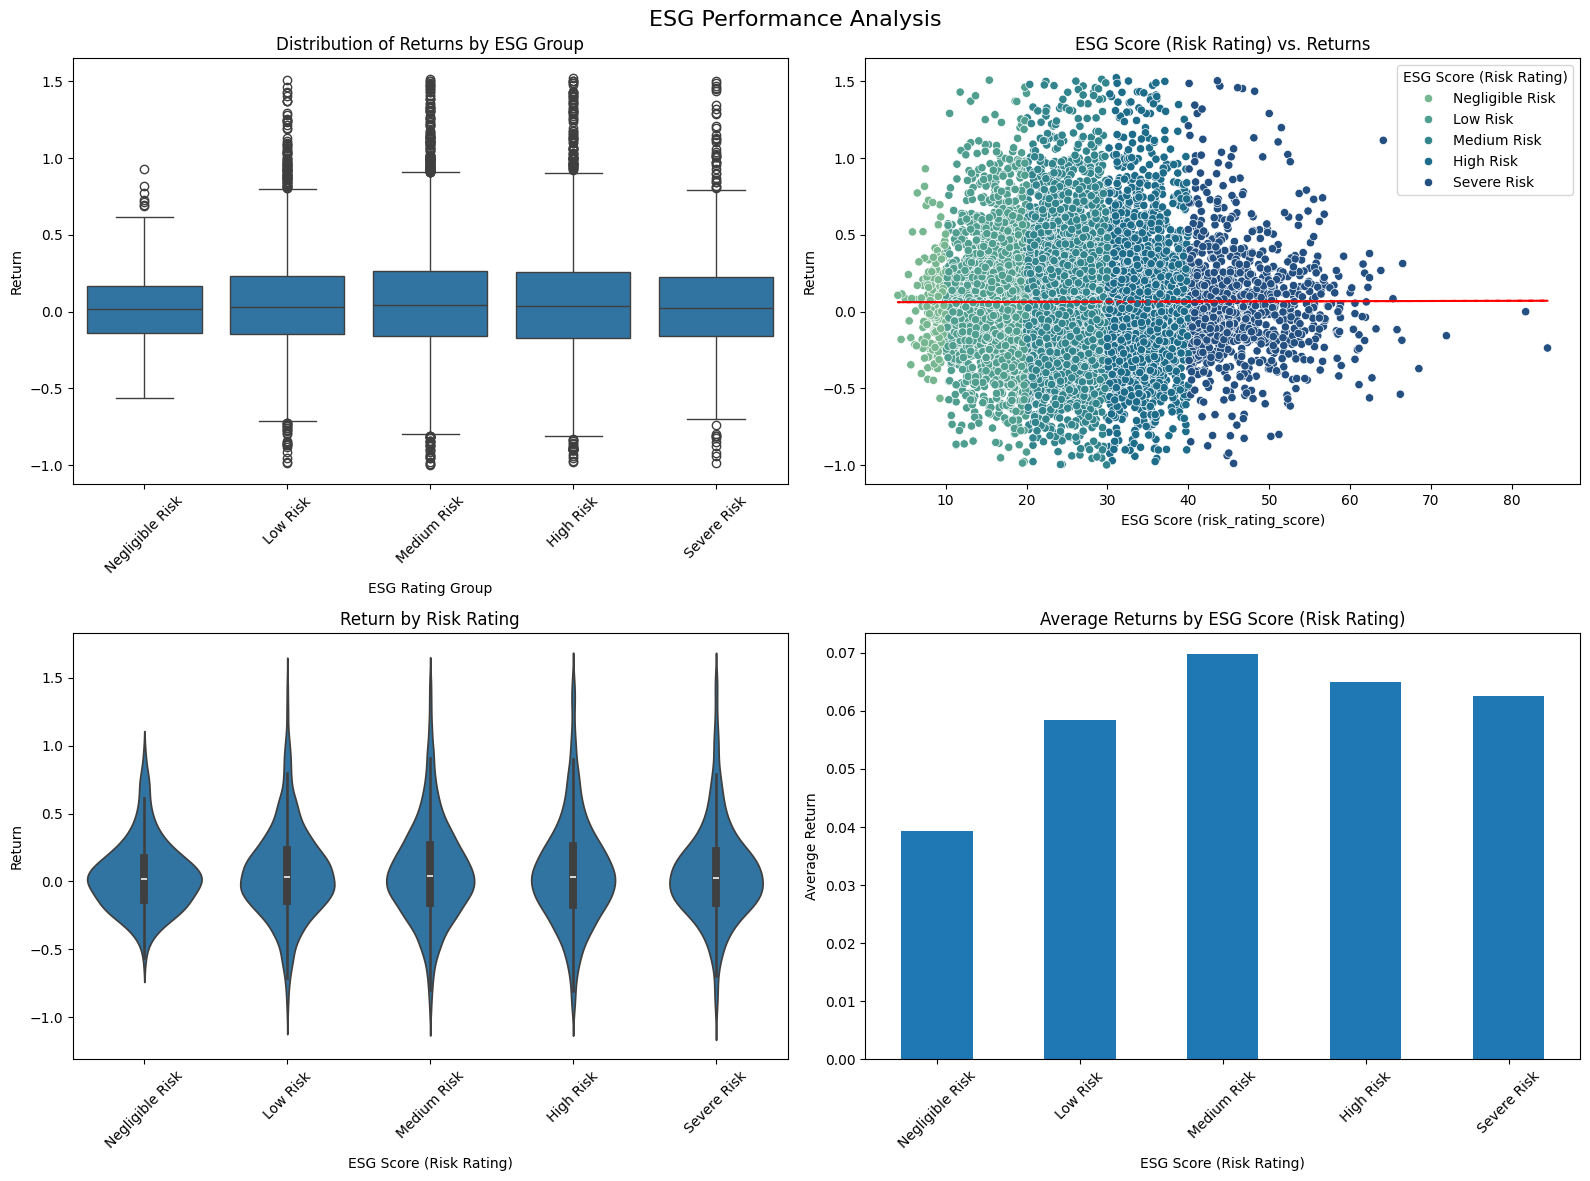


ANOVA Results: F-value=0.7052, p-value=0.5883

Pairwise t-tests (Bonferroni corrected):
Negligible Risk vs Low Risk: t=-1.0070, p=3.1488
Negligible Risk vs Medium Risk: t=-1.6400, p=1.0229
Negligible Risk vs High Risk: t=-1.3293, p=1.8484
Negligible Risk vs Severe Risk: t=-1.0988, p=2.7252
Low Risk vs Medium Risk: t=-1.3681, p=1.7132
Low Risk vs High Risk: t=-0.6726, p=5.0122
Low Risk vs Severe Risk: t=-0.3165, p=7.5164
Medium Risk vs High Risk: t=0.5266, p=5.9849
Medium Risk vs Severe Risk: t=0.5899, p=5.5533
High Risk vs Severe Risk: t=0.1860, p=8.5244


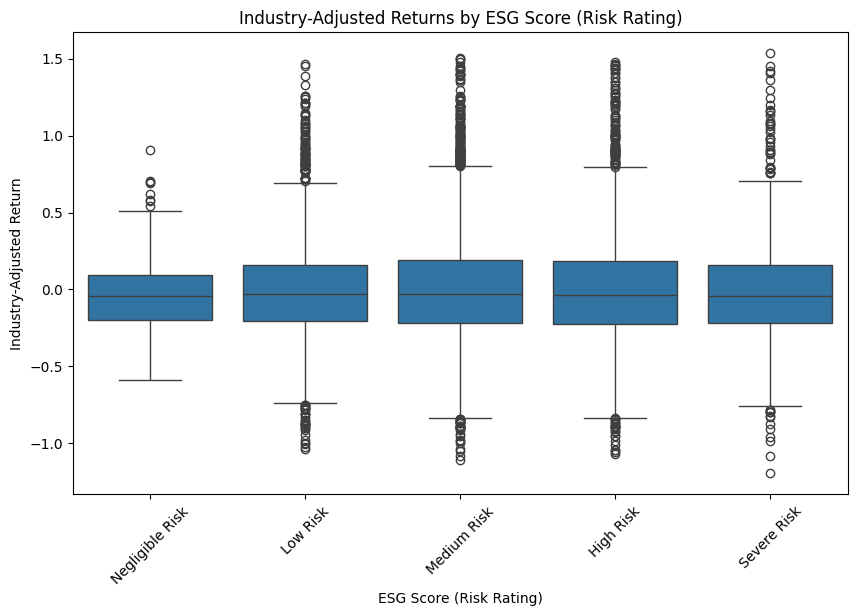

In [26]:
# Basic analysis
summary_stats, corr_matrix = basic_analysis_return(df_use)
# Visualization
create_visualizations_return(df_use)
# Statistical testing
perform_statistical_tests_return(df_use)
# Industry-adjusted analysis if industry data available
industry_adjusted_analysis_return(df_use)

In [27]:
df_outlier_vol=df[find_extreme_outliers(df, 'volatility')]
df_outlier_vol_gr=df_outlier_vol.groupby('country')
print('Total data', len(df))
print('Total outlier volatility data ', len(df_outlier_vol))
print(df_outlier_vol_gr.size())
df_use_vol=df[~find_extreme_outliers(df, 'volatility')]
print('Data is use for volatility ',len(df_use_vol))

Total data 11429
Total outlier volatility data  155
country
Australia                     4
Brazil                        4
Canada                        2
China                        19
France                        2
Germany                       1
Hong Kong                     5
India                         2
Indonesia                     1
Malaysia                      1
Mexico                        1
Singapore                     1
South Korea                   2
Switzerland                   3
Thailand                      1
United Kingdom                3
United States of America    103
dtype: int64
Data is use for volatility  11274


In [28]:
def basic_analysis_volatility(df):
    """Perform initial statistical analysis"""
    # Summary statistics by ESG group
    summary = df.groupby('risk_rating_assessment').agg({
        'volatility': ['mean', 'median', 'std', 'count'],
        'risk_rating_score': ['mean', 'median']  # Show ESG score relationship
    }).round(4)
    
    print("Performance by ESG Group:")
    print(summary)
    
    # Correlation analysis
    corr_matrix = df[['risk_rating_score', 'volatility']].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    return summary, corr_matrix
def create_visualizations_volatility(df):
    """Generate all visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ESG Performance Analysis', fontsize=16)
    
    # Boxplot of volatility by ESG group
    sns.boxplot(x='risk_rating_assessment', y='volatility', data=df, ax=axes[0, 0], 
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[0, 0].set_title('Distribution of Volatility by ESG Group')
    axes[0, 0].set_ylabel('Volatility')
    axes[0, 0].set_xlabel('ESG Rating Group')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Scatter plot of ESG score vs volatility
    sns.scatterplot(x='risk_rating_score', y='volatility', hue='risk_rating_assessment',
                    data=df, ax=axes[0, 1], palette='crest',
                    hue_order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    # Calculate the regression line using np.polyfit
    m, b = np.polyfit(df['risk_rating_score'], df['volatility'], 1)  # 1 for a linear fit
    axes[0, 1].plot(df['risk_rating_score'], m * df['risk_rating_score'] + b, color='red', linestyle='--')
    
    axes[0, 1].set_title('ESG Score (Risk Rating) vs. Volatility')
    axes[0, 1].set_ylabel('Volatility')
    axes[0, 1].set_xlabel('ESG Score (risk_rating_score)')
    axes[0, 1].legend(title='ESG Score (Risk Rating)')

    
    # Violin plot of volatility by risk rating
    sns.violinplot(x='risk_rating_assessment', y='volatility', data=df, ax=axes[1, 0],
                   order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[1, 0].set_title('Volatility by ESG Score (Risk Rating)')
    axes[1, 0].set_ylabel('Volatility')
    axes[1, 0].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    
    # Bar plot of average volatility
    (df.groupby('risk_rating_assessment')['return']
       .mean()
       .loc[['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']]
       .plot(kind='bar', ax=axes[1, 1]))
    axes[1, 1].set_title('Average Volatility by ESG Score (Risk Rating)')
    axes[1, 1].set_ylabel('Average Volatility')
    axes[1, 1].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    
    plt.tight_layout()
    # plt.savefig('esg_performance_analysis.png', dpi=300)
    plt.show()

def perform_statistical_tests_volatility(df):
    """Conduct hypothesis testing"""
    groups = {}
    risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    
    for risk_group in risk_order:
        groups[risk_group] = df[df['risk_rating_assessment'] == risk_group]['volatility']
    
    # ANOVA test for multiple group comparison
    f_val, p_val = stats.f_oneway(*[groups[g].dropna() for g in risk_order])
    print(f"\nANOVA Results: F-value={f_val:.4f}, p-value={p_val:.4f}")
    
    # Pairwise t-tests between groups
    from itertools import combinations
    print("\nPairwise t-tests (Bonferroni corrected):")
    for group1, group2 in combinations(risk_order, 2):
        # Drop NA values for t-test
        data1 = groups[group1].dropna()
        data2 = groups[group2].dropna()
        
        if len(data1) > 1 and len(data2) > 1:  # Need at least 2 observations
            t_val, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            # Bonferroni correction for multiple comparisons (10 possible pairs)
            corrected_p = p_val * 10
            sig = '*' if corrected_p < 0.05 else ''
            print(f"{group1} vs {group2}: t={t_val:.4f}, p={corrected_p:.4f}{sig}")
        else:
            print(f"{group1} vs {group2}: Insufficient data")


def industry_adjusted_analysis_volatility(df):
    """Control for industry effects"""
    # Calculate industry-adjusted volatility
    df['industry_mean_volatility'] = df.groupby('industry_group')['volatility'].transform('mean')
    df['adjusted_volatility'] = df['volatility'] - df['industry_mean_volatility']
    
    # Plot adjusted volatility
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk_rating_assessment', y='adjusted_volatility', data=df,
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    plt.title('Industry-Adjusted Volatility by ESG Score (Risk Rating)')
    plt.ylabel('Industry-Adjusted Volatility')
    plt.xlabel('ESG Score (Risk Rating)')
    plt.xticks(rotation=45)
    # plt.savefig('industry_adjusted_volatility.png', dpi=300, bbox_inches='tight')
    plt.show()


Performance by ESG Group:
                       volatility                       risk_rating_score  \
                             mean  median     std count              mean   
risk_rating_assessment                                                      
High Risk                  0.4214  0.3866  0.1757  2690           34.1291   
Low Risk                   0.3489  0.3182  0.1513  2806           16.1341   
Medium Risk                0.3921  0.3590  0.1695  4574           24.9611   
Negligible Risk            0.2879  0.2608  0.1172   206            8.4199   
Severe Risk                0.4253  0.3914  0.1566   998           46.8524   

                               
                       median  
risk_rating_assessment         
High Risk                33.7  
Low Risk                 16.5  
Medium Risk              24.9  
Negligible Risk           8.6  
Severe Risk              45.4  

Correlation Matrix:
                   risk_rating_score  volatility
risk_rating_score           1.0

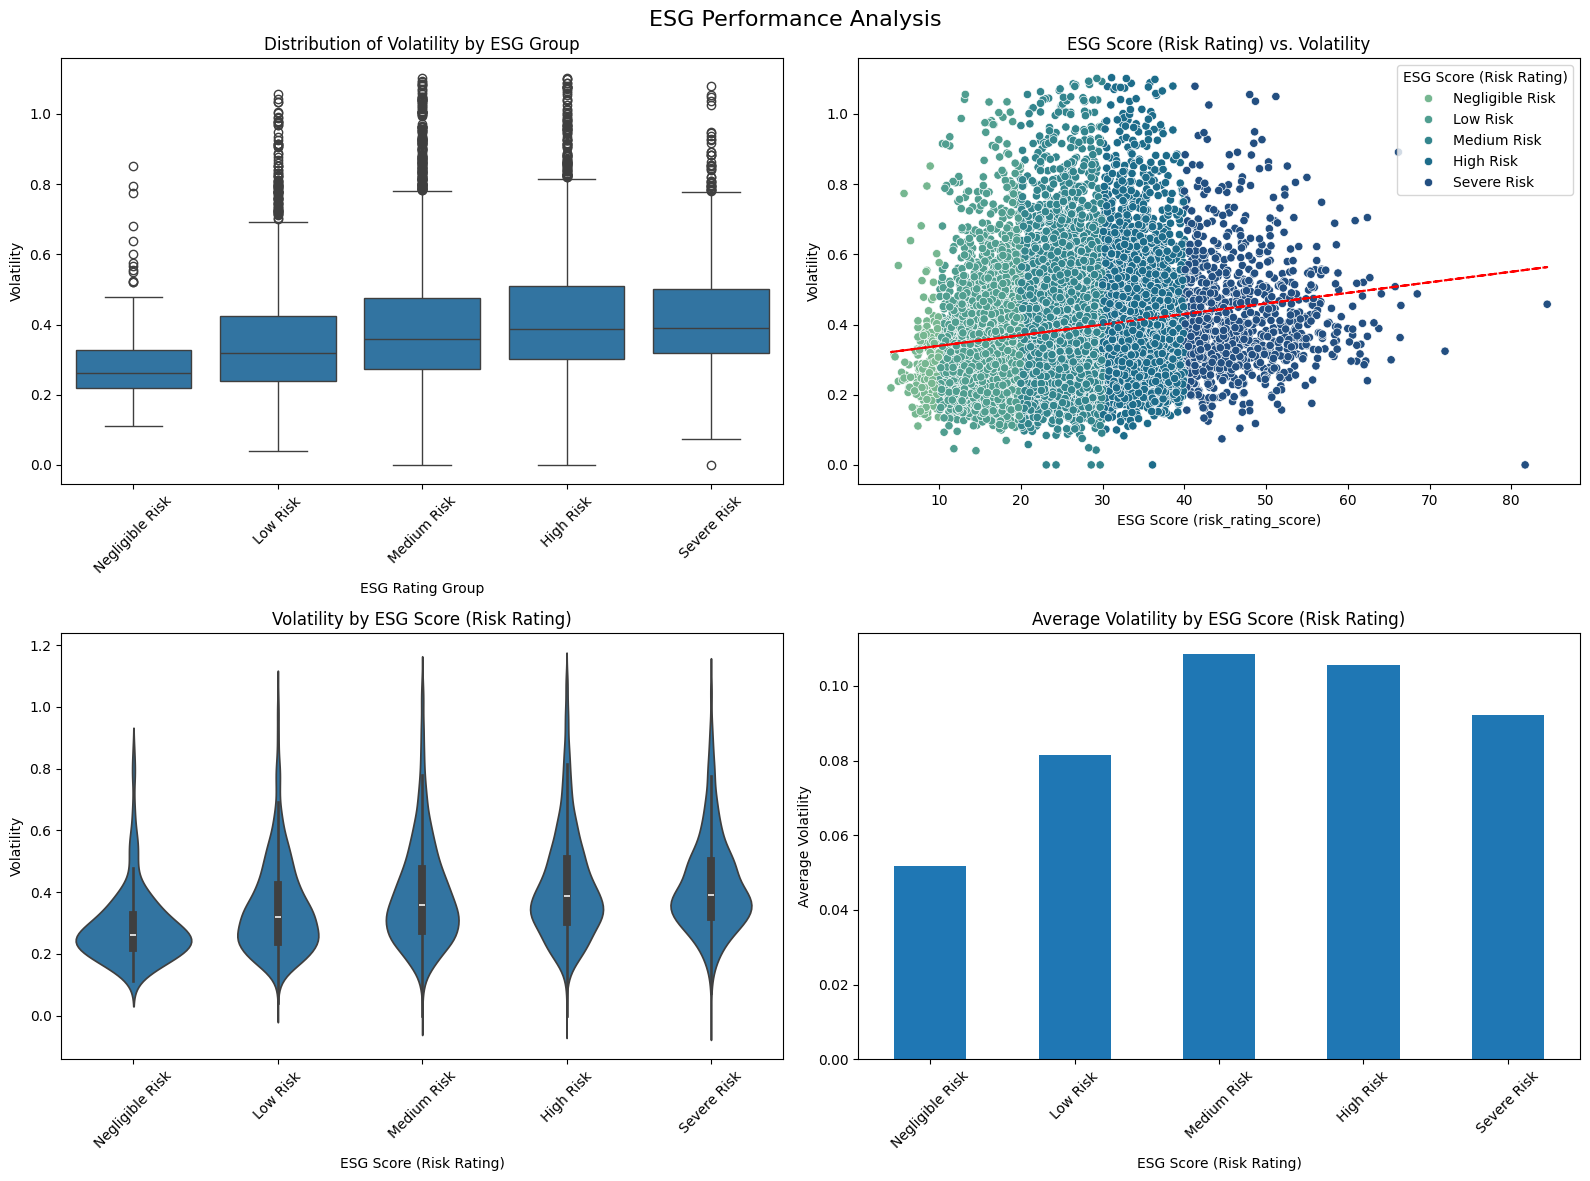


ANOVA Results: F-value=99.6057, p-value=0.0000

Pairwise t-tests (Bonferroni corrected):
Negligible Risk vs Low Risk: t=-7.0467, p=0.0000*
Negligible Risk vs Medium Risk: t=-12.1978, p=0.0000*
Negligible Risk vs High Risk: t=-15.1082, p=0.0000*
Negligible Risk vs Severe Risk: t=-14.3845, p=0.0000*
Low Risk vs Medium Risk: t=-11.3744, p=0.0000*
Low Risk vs High Risk: t=-16.3841, p=0.0000*
Low Risk vs Severe Risk: t=-13.3606, p=0.0000*
Medium Risk vs High Risk: t=-6.9684, p=0.0000*
Medium Risk vs Severe Risk: t=-5.9798, p=0.0000*
High Risk vs Severe Risk: t=-0.6425, p=5.2060


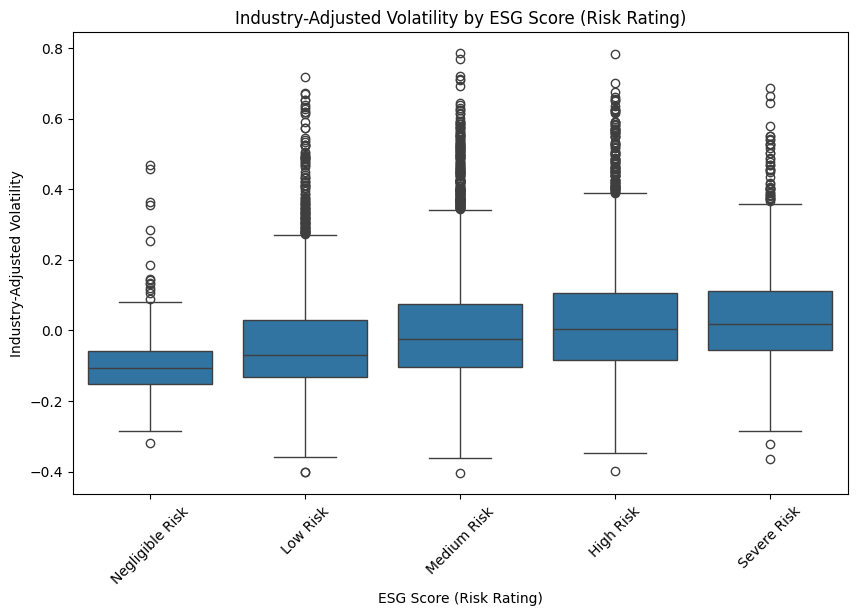

In [29]:
# Basic analysis
summary_stats, corr_matrix = basic_analysis_volatility(df_use_vol)
# Visualization
create_visualizations_volatility(df_use_vol)
# Statistical testing
perform_statistical_tests_volatility(df_use_vol)
# Industry-adjusted analysis if industry data available
industry_adjusted_analysis_volatility(df_use_vol)

Positive Relationship:

Higher ESG groups show statistically significant higher volatility (p < 0.05)

Upward slope in the ESG vs returns scatter plot

Rightward progression in the average returns bar chart



In [80]:
## 1. Data Preparation
def prepare_market_data(df):
    """Prepare data for market comparison analysis"""
    
    # Create market classification (if not already present)
    if 'market_class' not in df.columns:
        # Example classification - you should replace with your actual classification
        developed_markets = ['United States of America', 'United Kingdom', 'Germany', 'Japan', 'Canada', 'France']
        df['market_class'] = df['country'].apply(
            lambda x: 'Developed' if x in developed_markets else 'Emerging'
        )
    
    # # Create risk rating order
    # risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    # df['risk_rating_assessment'] = pd.Categorical(
    #     df['risk_rating_assessment'],
    #     categories=risk_order,
    #     ordered=True
    # )
    
    return df

## 2. Comparative Analysis
def market_comparison_analysis_return(df):
    """Compare ESG impact across market types"""
    # Summary statistics by market class
    market_summary = df.groupby('market_class').agg({
        'return': ['mean', 'median', 'std', 'count'],
        # 'volatility': ['mean', 'median'],
        'risk_rating_score': ['mean', 'median']
    }).round(4)
    
    print("Market Classification Summary:")
    print(market_summary)
    
    # ESG-return correlation by market class
    print("\nCorrelation by Market Class:")
    print(df.groupby('market_class')[['risk_rating_score', 'return']].corr())
    
    return market_summary

## 3. Visualization
def create_market_comparison_plots_return(df):
    """Create visualizations comparing market types"""
    fig = plt.figure(figsize=(18, 16))
    
    # Plot 1: Boxplot of returns by market class
    ax1 = plt.subplot2grid((3, 2), (0, 0))
    sns.boxplot(x='market_class', y='return', data=df, ax=ax1)
    ax1.set_title('Return Distribution by Market Type')
    
    # Plot 2: Scatter plot of ESG vs returns
    ax2 = plt.subplot2grid((3, 2), (0, 1))
    sns.scatterplot(x='risk_rating_score', y='return', hue='market_class',
                    data=df, alpha=0.6, ax=ax2)
    ax2.set_title('ESG Score vs Returns by Market Type')
    
    # Plot 3: FacetGrid of risk rating impact
    ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    g = sns.boxplot(x='risk_rating_assessment', y='return', hue='market_class',
                    data=df, order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'],
                    ax=ax3)
    ax3.set_title('Risk Rating Impact by Market Type')
    ax3.set_xlabel('Risk Rating')
    ax3.set_ylabel('Return')
    plt.setp(ax3.get_xticklabels(), rotation=45)
    
    # Plot 4: Regression plot
    ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    sns.regplot(x='risk_rating_score', y='return', 
                data=df[df['market_class']=='Developed'],
                ax=ax4, label='Developed', scatter_kws={'alpha':0.3})
    sns.regplot(x='risk_rating_score', y='return', 
                data=df[df['market_class']=='Emerging'],
                ax=ax4, label='Emerging', scatter_kws={'alpha':0.3})
    ax4.set_title('ESG Score vs Returns Regression by Market Type')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('market_comparison_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Statistical Testing
def perform_market_comparison_tests_return(df):
    """Statistical tests for market differences with robust ANOVA implementation"""
    # 1. Data preparation
    df_clean = df.copy()
    
    # Convert numeric columns safely
    numeric_cols = ['return', 'risk_rating_score']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Clean market_class and filter valid values
    df_clean['market_class'] = df_clean['market_class'].astype(str).str.strip()
    valid_markets = ['Developed', 'Emerging']
    df_clean = df_clean[df_clean['market_class'].isin(valid_markets)]
    
    # Drop missing values
    df_clean = df_clean.dropna(subset=['return', 'risk_rating_score', 'market_class'])
    
    # 2. Basic comparisons
    print("=== Basic Market Comparisons ===")
    print(f"Developed Markets: {len(df_clean[df_clean['market_class'] == 'Developed'])} samples")
    print(f"Emerging Markets: {len(df_clean[df_clean['market_class'] == 'Emerging'])} samples")
    
    # 3. ANOVA with interaction - ROBUST IMPLEMENTATION
    print("\n=== ANOVA with Interaction Effect ===")
    try:
        # Approach 1: Using patsy dmatrices directly
        from patsy import dmatrices
        
        y, X = dmatrices('return ~ risk_rating_score * market_class', 
                         data=df_clean,
                         return_type='dataframe')
        
        model = sm.OLS(y, X).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(anova_table)
        
        # Alternative approach if above fails
    except Exception as e:
        print(f"Standard ANOVA failed: {str(e)}")
        print("\nUsing alternative implementation...")
        
        try:
            # Approach 2: Manual dummy coding
            X = pd.get_dummies(df_clean[['risk_rating_score', 'market_class']], 
                              columns=['market_class'],
                              drop_first=True)
            X['interaction'] = X['risk_rating_score'] * X['market_class_Developed']
            X = sm.add_constant(X)
            
            model = sm.OLS(df_clean['return'], X).fit()
            
            # Manually create ANOVA table
            anova_results = {
                'df': [model.df_model, model.df_resid],
                'sum_sq': [model.ess, model.ssr],
                'F': [model.fvalue, np.nan],
                'PR(>F)': [model.f_pvalue, np.nan]
            }
            anova_table = pd.DataFrame(anova_results,
                                     index=['Model', 'Residual'])
            print("\nANOVA Results:")
            print(anova_table)
            
            print("\nCoefficients:")
            print(model.summary())
            
        except Exception as e2:
            print(f"Alternative ANOVA also failed: {str(e2)}")
            print("\nDebugging info:")
            print("Data types:", df_clean.dtypes)
            print("Sample data:")
            print(df_clean[['return', 'risk_rating_score', 'market_class']].head())
    
    # 4. Return the cleaned data for inspection
    return df_clean

## 5. Industry-Adjusted Analysis
def industry_adjusted_market_comparison_return(df):
    """Control for industry effects in market comparison"""
    if 'industry_group' in df.columns:
        # Calculate industry-adjusted returns
        df['industry_mean_return'] = df.groupby('industry_group')['return'].transform('mean')
        df['adjusted_return'] = df['return'] - df['industry_mean_return']
        
        # Plot adjusted returns by market class and ESG
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='risk_rating_assessment', y='adjusted_return', hue='market_class',
                    data=df, order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
        plt.title('Industry-Adjusted Returns by Risk Rating and Market Type')
        plt.ylabel('Industry-Adjusted Return')
        plt.xlabel('Risk Rating')
        plt.legend(title='Market Type')
        plt.xticks(rotation=45)
        plt.savefig('industry_adjusted_market_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()


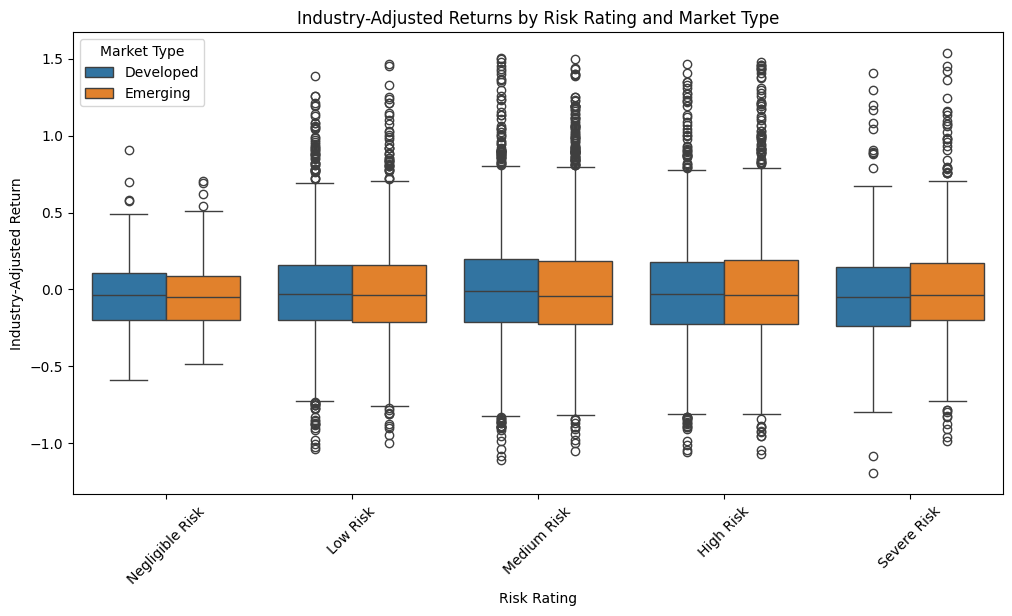

In [83]:
# dfs = df.groupby('country').size()
# print(dfs.index)
# print(len(dfs))
# df_volg = df_use.groupby('country').size()
# print(df_volg.index)
# print(len(df_volg))

# df_use = prepare_market_data(df_use)
# df_use.head()

# Basic comparison
# market_summary = market_comparison_analysis_return(df_use)

# Visualization
# create_market_comparison_plots_return(df_use)

# Statistical testing
# perform_market_comparison_tests_return(df_use)

# Industry-adjusted analysis
industry_adjusted_market_comparison_return(df_use)


In [88]:
# df_use = find_extreme_outliers(df_use, 'volatility')
df_use.info()

<class 'pandas.core.series.Series'>
Index: 11261 entries, 7559 to 9030
Series name: volatility
Non-Null Count  Dtype
--------------  -----
11261 non-null  bool 
dtypes: bool(1)
memory usage: 99.0 KB


In [85]:
def plot_volatility_relationships(df):
    """Create visualizations of volatility relationships"""
    plt.figure(figsize=(18, 12))
    
    # 1. ESG Score vs Volatility by Market Type
    plt.subplot(2, 2, 1)
    sns.scatterplot(x='risk_rating_score', y='volatility', hue='market_class',
                    data=df, alpha=0.6, palette='viridis')
    plt.title('ESG Score vs. Volatility by Market Type')
    plt.xlabel('ESG Score (Lower = Better)')
    plt.ylabel('Annualized Volatility')
    
    # 2. Boxplot of Volatility by Risk Category
    plt.subplot(2, 2, 2)
    sns.boxplot(x='risk_category', y='volatility', hue='market_class',
                data=df, showfliers=False)
    plt.title('Volatility Distribution by ESG Risk Category')
    plt.xlabel('ESG Risk Category')
    plt.ylabel('Volatility')
    plt.xticks(rotation=45)
    
    # 3. Regression Plot with Confidence Intervals
    plt.subplot(2, 2, 3)
    sns.lmplot(x='risk_rating_score', y='volatility', hue='market_class',
               data=df, height=6, aspect=1.5, ci=95)
    plt.title('ESG Score vs. Volatility Regression')
    plt.xlabel('ESG Score')
    plt.ylabel('Volatility')
    
    # 4. Faceted Density Plots
    plt.subplot(2, 2, 4)
    g = sns.FacetGrid(df, col='market_class', height=5)
    g.map(sns.kdeplot, 'volatility', hue='risk_category', 
          palette='viridis', alpha=0.5, fill=True)
    g.add_legend()
    plt.suptitle('Volatility Distribution by Market Type and ESG Risk', y=1.02)
    
    plt.tight_layout()
    plt.savefig('esg_volatility_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()



TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

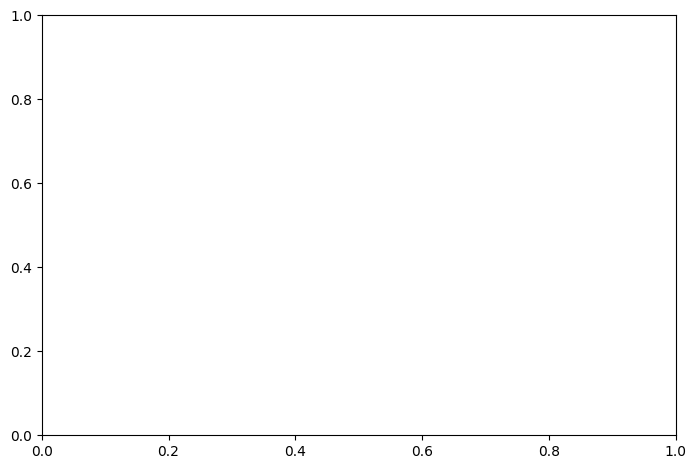

In [87]:
plot_volatility_relationships(df_use)